In [1]:
# Perform the initialization and imports
import sys
import pickle
import re
import os
import csv
import argparse
import math

from string import ascii_lowercase
from collections import Counter, defaultdict
from operator import itemgetter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.Emboss.Applications import NeedleallCommandline

# Demand Python 3.
if sys.version_info[0] < 3:
    print("Python 3 is required, but you are using Python %i.%i.%i") % (
        sys.version_info[0], sys.version_info[1], sys.version_info[2])
    sys.exit(1)

In [2]:
# Retrieve the specific functions from ind and proteins.py
indels_path="/home/maya/InDelScanner"  # /PATH/TO/InDelScanner
if indels_path not in sys.path:
    sys.path.append(indels_path)

from ipynb.fs.defs.Library_diversity import convert_variant_to_dict, single_fraction_enrichment

os.chdir("/mnt/c/Users/Maya/Documents/03_Kinases/")

with open('mek.pickle', 'rb') as pf:
    mek = pickle.load(pf)

with open('df_pos.pickle', 'rb') as pf:
    df_pos = pickle.load(pf)
    
pos = df_pos.to_dict()

# Set general restrictions stemming from SpliMLib library design
aa_2 = ['A', 'Δ']
aa_12 = ['A','G','P','Y','D','K','M','V','I','L','F','W']
aa_13 = aa_12 +  ['Δ']
splimlib = {'6': aa_12, '9': aa_12, '11': aa_12, '13': aa_12, '7a': aa_13, '8a': aa_2}

In [3]:
active_ls = df_pos.index.tolist()
active = {short : convert_variant_to_dict(short) for short in active_ls}
valid_pos = ['6', '7a', '8a', '9', '11', '13']

data = {}
for short, m_to_pos in active.items():
    if len(m_to_pos) != len(valid_pos):
        continue
    else:
        data[short] = [m_to_pos[i] for i in valid_pos]

factors = pd.DataFrame.from_dict(data, orient='index', columns=valid_pos).reset_index(drop=False)

In [4]:
factors.to_pickle('mkk_factors.gzip')

## GraphML

In [5]:
import random

In [6]:
test = random.sample(active.items(), 1000)
test_dict = {}
for i in range(len(test)):
    test_dict[test[i][0]] = test[i][1]

In [7]:
# hamming distance = 0 if the aa matches at all positions
def hamming_distance(s1, s2, splimlib):
    d = 0
    if (len(s1) != len(splimlib)) or (len(s2) != len(splimlib)):
        d += 2

    for p in splimlib.keys():
        if s1[p] != s2[p]:
            d += 1
    return d

In [8]:
# make a list of edges
def list_edge_nodes(active, splimlib):
    node_pairs = []
    for short1, s1 in active.items():
        for short2, s2 in active.items():
            h_dis = hamming_distance(s1, s2, splimlib)
            if h_dis == 1:
                node_pairs.append((short1, short2))
    return node_pairs

In [9]:
header = '<?xml version="1.0" encoding="utf-8"?>'
graphml_open = '<graphml xmlns="http://graphml.graphdrawing.org/xmlns" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" \
    xsi:schemaLocation="http://graphml.graphdrawing.org/xmlns  http://graphml.graphdrawing.org/xmlns/1.0/graphml.xsd">'
graph_open = '<graph edgedefault="undirected">'

close = '</graph>\n</graphml>'

In [10]:
# GRAPHML functions

# create nodes
def gml_write_node(short, file):
    print('<node id=\"{node}"/>'.format(node=short), sep="", file=file)

def gml_list_edge_strings(node_pairs):
    edge_strings = []
    for pair in node_pairs:
        edge_id = '-'.join(pair)
        one_edge = '<edge id="{id}" source="{s}" target="{t}"/>'.format(
            id=edge_id, s=pair[0], t=pair[1])
        edge_strings.append(one_edge)
    return edge_strings

Now write the graph file.

In [14]:
def write_graphml(graph_dict, filename):
    with open (filename, 'w') as f:
        # print the GRAPHML header definitions
        print(header, graphml_open, graph_open, file=f, sep='\n')

        # write nodes
        for short in graph_dict.keys():
            gml_write_node(short, f)

        # write edges
        node_pairs = list_edge_nodes(graph_dict, splimlib)
        edge_strings = gml_list_edge_strings(node_pairs)
        f.writelines(edge_strings)

        # end the graph and graphml
        print(close, file=f)
    
    return node_pairs

In [15]:
active_edges = write_graphml(active, 'active.graphml')

## Sequence similarity network analysis with NetworkX

In [16]:
import networkx as nx

In [17]:
g_ham = nx.read_graphml('active.graphml')

In [18]:
# AVERAGE NODE DEGREE
g_ham.size() / g_ham.order()

11.560193485099617

In [19]:
ham_components = list(g_ham.subgraph(c) for c in nx.connected_components(g_ham))

In [20]:
len(ham_components)

952

It is justified to only examine the largest connected subgraph, since the next subgraphs have very few nodes: 5 (2x), 4 (4x), 3 (12x) or less.

In [46]:
component_lens = {i: len(ham_components[i]) for i in range(len(ham_components))} # get the number of nodes in the largest subgraphs

sort_components = sorted(component_lens.items(), key=lambda x: x[1], reverse=True)

for i in sort_components[:10]:
	print(i[0], i[1])

0 28497
114 5
14 4
31 4
161 4
11 3
26 3
55 3
130 3
197 3


In [22]:
G = ham_components[0]

In [23]:
G.size()/G.order()

11.984419412569745

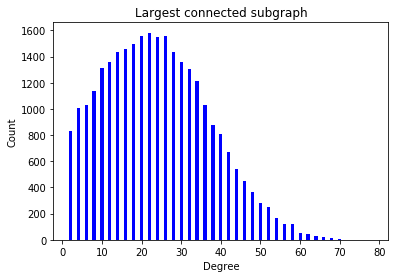

In [24]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Largest connected subgraph")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

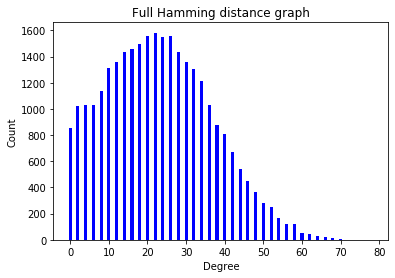

In [25]:
degree_sequence = sorted([d for n, d in g_ham.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Full Hamming distance graph")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

This is looking promising. At this point, take the largest subgraph into Gephi to build a good visualisation.

In [26]:
nx.write_graphml(G, 'Largest_connected_26563vars.graphml')

In [28]:
G.degree('6P/9I/11L/13P')

26

In [32]:
H = nx.Graph()
# copy over the nodes from G
for n in G.nodes():
    H.add_node(n, deg=G.degree[n])
for e in G.edges():
    H.add_edge(e[0], e[1])

Now let's start experimenting with pruning.

https://stackoverflow.com/questions/18381187/functions-for-pruning-a-networkx-graph

One option is to try pruning nodes according to betweeness centrality. First, calculate the betweeness centrality for all nodes, identifying the ones that are 'hubs': appear in many shortest paths between nodes. Plot a distribution on betcen to get an idea of the values.

In [33]:
# Closeness centrality
clo_cen = nx.closeness_centrality(H)

In [34]:
with open('H_closeness_centrality.pickle', 'wb') as f:
    pickle.dump(clo_cen, f)

In [35]:
# Betweenness centrality
bet_cen = nx.betweenness_centrality(H)

In [36]:
with open('H_betweenness_centrality.pickle', 'wb') as f:
    pickle.dump(clo_cen, f)

In [37]:
eig_cen = nx.eigenvector_centrality(H)

with open('H_eigenvector_centrality.pickle', 'wb') as f:
    pickle.dump(eig_cen, f)

In [38]:
nx.set_node_attributes(H, clo_cen, 'closeness')
nx.set_node_attributes(H, bet_cen, 'betweenness')
nx.set_node_attributes(H, eig_cen, 'eigenvector')

In [40]:
H.order()

28497

In [43]:
degree_dict = dict(H.degree(H.nodes()))
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 20 nodes by degree:")
for d in sorted_degree[:20]:
    print(d)

Top 20 nodes by degree:
('6L/7aI/8aA/9L/11I/13M', 39)
('6L/7aI/9I/11L/13I', 38)
('6L/7aI/8aA/9L/11I/13I', 38)
('6W/7aP/8aA/9L/11L/13I', 37)
('6L/7aI/8aA/9L/11L/13M', 36)
('6L/7aI/9I/11I/13I', 36)
('6F/7aI/8aA/9L/11I/13W', 35)
('6L/7aI/9I/11L/13W', 35)
('6L/7aI/9V/11L/13I', 35)
('6L/7aI/9I/11I/13M', 35)
('6L/7aI/8aA/9L/11L/13L', 35)
('6W/7aP/8aA/9L/11L/13P', 35)
('6L/7aI/8aA/9L/11I/13K', 35)
('6L/7aI/8aA/9L/11F/13M', 34)
('6L/7aI/9I/11I/13V', 34)
('6F/7aG/8aA/9L/11L/13I', 34)
('6L/7aI/8aA/9L/11L/13W', 34)
('6P/9L/11L/13W', 34)
('6V/8aA/9L/11I/13V', 34)
('6F/7aL/9L/11I/13F', 34)


In [44]:
nx.diameter(H)

16

In [48]:
wt_short = '6P/9I/11L/13P'
wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}

H_dist = {}
for n in H.nodes():
    s1 = convert_variant_to_dict(n)
    H_dist[n] = hamming_distance(wt, s1, splimlib)

In [50]:
nx.set_node_attributes(H, H_dist, "Hamming")

In [53]:
nx.write_graphml(H, 'connected_annotated.graphml')